In [48]:
from langgraph.graph import StateGraph, START, END

from langgraph.checkpoint.redis import RedisSaver
from states import *
from prompts import *
import dotenv
dotenv.load_dotenv()

from parsers import parse_directory_files

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from states import State, DocMetadata, Tasks, DocumentWithMetadata, DocumentToTaskMapper, ExecutionAgent
from prompts import METADATA_EXTRACTOR_PROMPT, TASK_PARSER_PROMPT, DOCUMENT_TO_TASK_MAPPER_PROMPT
from parsers import parse_directory_files
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI


In [2]:
# from langchain_openai import ChatOpenAI

# model = ChatOpenAI(model="o4-mini", reasoning_effort="high")
# # state = State(data_path="/Users/omar/work/andrea/data")

# files = parse_directory_files("/Users/omar/work/andrea/data_temp")




In [17]:
files = parse_directory_files("/Users/omar/work/andrea/data")

for file in files:
    print(file['file_name'])
    print(file['content'])
    print("--------------------------------")

16:07:50 httpx INFO   HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
16:08:02 httpx INFO   HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
16:08:06 httpx INFO   HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
16:08:10 httpx INFO   HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
16:08:15 httpx INFO   HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
employee_payroll.png
ACME Inc.

Payroll Register

Display Retro Results: No
Hide Zero Gross and Zero Net Results: No
Period: 7/20/2024 - 08/02/2024 (Non-Exempt BI-Weekly (WDPAY))
Pay Run Groups and/or Pay Group Details: Non-Exempt Hourly - Regular

Row 1:
Group Name: US Hourly CA (2nd Check) (Pay Group Detail)
Payroll Result: 7/20/2024 - 8/2/2024 (Non-Exempt BI-Weekly (WDPAY1)) (Period)
Worker: 
Gross Pay: 0
Add to Gross - PCG - Class Report Field: 0
Federal Taxable Don't W/H - PCG - Class Report Field: 0
Federal Taxabl

In [ ]:
# import pickle

# # write pickle

# with open('files.pkl', 'wb') as f:
#     pickle.dump(files, f)

# # with open('state.pkl', 'rb') as f:
# #     state = pickle.load(f)


In [77]:
from pydantic import BaseModel, Field
from typing import List



class DocMetadata(BaseModel):
    name: str = Field(description="The name of the document", default="")
    purpose: str = Field(description="The purpose of the document", default="")
    possible_use_cases: str = Field(description="The possible use cases of the document", default="")

class DocumentWithMetadata(BaseModel):
    name: str = Field(description="The name of the document", default="")
    purpose: str = Field(description="The purpose of the document", default="")
    possible_use_cases: str = Field(description="The possible use cases of the document", default="")
    content: str = Field(description="The content of the document", default="")

class Task(BaseModel):
    task_id: str = Field(description="The id of the task", default="")
    task: str = Field(description="The task to be executed", default="")
class Tasks(BaseModel):
    tasks: List[Task] = Field(description="The tasks to be executed", default=[])

class DocumentToTaskMapper(BaseModel):
    docs: List[str] = Field(description="The documents that are most relevant to the task", default=[])
    task_id: str = Field(description="The id of the task", default="")

class ExecutionAgent(BaseModel):
    task_id: str = Field(description="The id of the task", default="")
    output: str = Field(description="The output of the task", default="")

class State(BaseModel):
    data_path: str = Field(description="The path to the data", default="") #input
    tasks_raw: str = Field(description="The raw tasks", default="") #input


    docs_content_with_metadata: List[DocumentWithMetadata] = Field(description="The content of the documents with metadata", default=[])
    tasks_parsed: Tasks = Field(description="The parsed tasks", default=Tasks(tasks=[]))
    document_to_task_mapper: List[DocumentToTaskMapper] = Field(description="The documents selected for the tasks", default=[])
    execution_task_output: List[ExecutionAgent] = Field(description="The execution agent", default=[])

    reflector: str = Field(description="The reflector", default="")
    reporter: str = Field(description="The reporter", default="")

    task_max_iterations: int = Field(description="The maximum number of iterations for the task", default=1)


In [ ]:

model = ChatOpenAI(model="gpt-4.1-mini", ) #o4-mini #reasoning_effort="high"

def metadata_extractor(state: State):
    print("--------------------------------")
    print("Extracting metadata")
    # files = parse_directory_files(state['data_path'])

    
    print(state)

    for file in files:

        messages = [
            SystemMessage(content=METADATA_EXTRACTOR_PROMPT),
            HumanMessage(content="File Name: " + file['file_name'] + "\nFile Content: \n" + file['content'])
        ]


        response = model.with_structured_output(DocMetadata).invoke(messages)
        state.docs_content_with_metadata.append(DocumentWithMetadata(name=response.name, purpose=response.purpose, possible_use_cases=response.possible_use_cases, content=file['content']))
        print(file['file_name'], "\n", response)
    return state


def tasks_parser(state: State):
    print("--------------------------------")
    print("Parsing tasks")
    tasks = state.tasks_raw

    messages = [
        SystemMessage(content=TASK_PARSER_PROMPT),
        HumanMessage(content=tasks)
    ]

    response = model.with_structured_output(Tasks).invoke(messages)
    state.tasks_parsed = response
    print(response)
    return state
    

def document_to_task_mapper(state: State):
    print("--------------------------------")
    print("Mapping documents to tasks")
    for _, task in state.tasks_parsed.tasks:
        messages = [
            SystemMessage(content=DOCUMENT_TO_TASK_MAPPER_PROMPT),
            HumanMessage(content="Task: " + task + "\nDocuments: " + str(state.docs_content_with_metadata))
        ]

        response = model.with_structured_output(DocumentToTaskMapper).invoke(messages)
        state.document_to_task_mapper.append(response)
        print(task, "\n", response)
    return state


def execution_agent(state: State):
    print("--------------------------------")
    print("Executing tasks")
    
    for task in state.document_to_task_mapper:
        messages = [
            SystemMessage(content=EXECUTION_AGENT_PROMPT),
            HumanMessage(content="Task: " + task + "\nDocuments: \n" + str(state.docs_content_with_metadata))
        ]

        response = model.with_structured_output(ExecutionAgent).invoke(messages)
        state.execution_task_output.append(response)
        print(task, "\n", response)
    
    return state

def reflector(state: State):
    return state

def reporter(state: State):
    return state

def should_continue(state: State):
    return state


16:26:28 langgraph.checkpoint.redis INFO   Redis client is a standalone client
16:26:28 redisvl.index.index INFO   Index already exists, not overwriting.
16:26:28 redisvl.index.index INFO   Index already exists, not overwriting.
16:26:28 redisvl.index.index INFO   Index already exists, not overwriting.


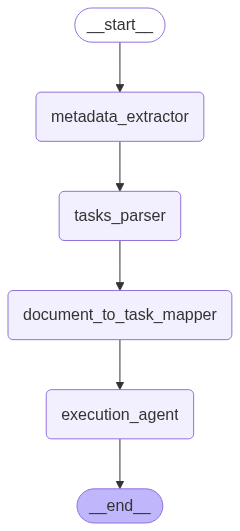

In [79]:


builder = StateGraph(State)
builder.add_node("metadata_extractor", metadata_extractor)
builder.add_node("tasks_parser", tasks_parser)
builder.add_node("document_to_task_mapper", document_to_task_mapper)
builder.add_node("execution_agent", execution_agent)
# builder.add_node("reflector", reflector)
# builder.add_node("reporter", reporter)

builder.add_edge(START, "metadata_extractor")
builder.add_edge("metadata_extractor", "tasks_parser")
builder.add_edge("tasks_parser", "document_to_task_mapper")
builder.add_edge("document_to_task_mapper", "execution_agent")
builder.add_edge("execution_agent", END)

# builder.add_edge("execution_agent", "reflector")

# builder.add_conditional_edges("reflector",should_continue, {"pass": "reporter",
#     "fail": "execution_agent"})

# # builder.add_edge("reflector", "reporter")
# builder.add_edge("reporter", END)

REDIS_URI = "redis://localhost:6379/0"
with RedisSaver.from_conn_string(REDIS_URI) as checkpointer:
    checkpointer.setup()
    
    graph = builder.compile(checkpointer=checkpointer)

graph


In [80]:
tasks = """TASKS:

1. Compare ADP payroll data, bank payroll data, and settlement runs payroll data. Make sure that the numeric totals are all the same


2. Compare employee payroll data from screenshots to the employee payroll data from the CSV. Make sure that the payroll amounts in the CSV match the payroll amounts in the screenshot. 


3. Compare employee total payroll data from screenshots to the total employee payroll from the CSV. Make sure the 2 payroll amounts match. 
"""

In [81]:
graph.invoke(input={"data_path": "/Users/omar/work/andrea/data", "tasks_raw": tasks}, config={"configurable": {"thread_id": "1"}})

--------------------------------
Extracting metadata
data_path='/Users/omar/work/andrea/data' tasks_raw='TASKS:\n\n1. Compare ADP payroll data, bank payroll data, and settlement runs payroll data. Make sure that the numeric totals are all the same\n\n\n2. Compare employee payroll data from screenshots to the employee payroll data from the CSV. Make sure that the payroll amounts in the CSV match the payroll amounts in the screenshot. \n\n\n3. Compare employee total payroll data from screenshots to the total employee payroll from the CSV. Make sure the 2 payroll amounts match. \n' docs_content_with_metadata=[DocumentWithMetadata(name='employee_payroll.png', purpose='This document is a payroll register that details the gross and net pay, tax withholdings, and payment status of hourly employees for a specific bi-weekly pay period.', possible_use_cases='The document can be used for payroll processing, auditing employee payments, verifying tax withholdings, financial accounting, and providin

KeyboardInterrupt: 

In [ ]:
# state = graph.get_state(config={"configurable": {"thread_id": "1"}}).values

ValidationError: 1 validation error for State
tasks_parsed
  Input should be a valid dictionary or instance of Tasks [type=model_type, input_value=[Task(task_id='1', task='...ayroll amounts match.')], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type